# Machine Learning Trading Bot

#### This file will show 2 examples applying different machine learning models to the same set of data utilizing the same variables for training. 

##### - This current study utilizes just the SPY index though data is available for all of the indexes.
##### - The models were trained on the following variables: We used the SVC Classifier Model and the Decision Tree Classifier. 
##### - The variables used for training were Open, High, Low, Close, Volume, SMA 5, SMA 10, SMA 20, SMA 50, SMA 100, SMA 200, RSI 14, MACD 12-26, P/E Ratio. (Interest rates were considered but hashed out for later analysis)
##### - The target variable was a buy-sell signal to predict whether the user should make a 10 day hold. The prediction was for a 10D price increase (buy) or decrease (sell).

In [1]:
# Import libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot
import numpy as np
import warnings
import pathlib as Path
import xgboost as xgb
import numpy as np
import talib as ta
from talib import MA_Type
from pandas.tseries.offsets import DateOffset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from pandas.tseries.offsets import DateOffset
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
#warnings.filterwarnings("ignore", category=SettingWithCopyWarning)

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

## Step 1: Gather and clean data

In [2]:
# Define the ETF symbols
etf_symbols = ['SPY', 'QQQ', 'IWM', 'DIA']

# Define the technical indicators
sma_periods = [5, 10, 20, 50, 100, 200]
rsi_periods = [14]
macd_periods = [(12, 26)]

# Create an empty DataFrame to store the data
data_df = pd.DataFrame()

# Fetch historical price data and append to the DataFrame
for symbol in etf_symbols:
    data = yf.download(symbol, start='2013-06-29', end='2023-06-29')
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    data['Symbol'] = symbol
    data_df = data_df.append(data)

# Set the index to date-time
data_df.set_index(data_df.index, inplace=True)

# Calculate technical indicators
for period in sma_periods:
    sma_column_name = f"SMA {period}"
    data_df[sma_column_name] = data_df.groupby('Symbol')['Close'].transform(lambda x: ta.SMA(x.values, timeperiod=period))

for period in rsi_periods:
    rsi_column_name = f"RSI {period}"
    data_df[rsi_column_name] = data_df.groupby('Symbol')['Close'].transform(lambda x: ta.RSI(x.values, timeperiod=period))

for short_period, long_period in macd_periods:
    macd_column_name = f"MACD {short_period}-{long_period}"
    data_df[macd_column_name] = data_df.groupby('Symbol')['Close'].transform(lambda x: ta.MACD(x.values, fastperiod=short_period, slowperiod=long_period, signalperiod=9)[0])

# Calculate price change
data_df['Price Change %-10d'] = data_df.groupby('Symbol')['Close'].transform(lambda x: (x - x.shift(10)) / x * 100)

# Calculate actual daily returns
data_df['Actual Returns'] = data_df.groupby('Symbol')['Close'].transform(lambda x: x.pct_change())


# Fetch P/E Ratio for each ETF
for symbol in etf_symbols:
    ticker = yf.Ticker(symbol)
    pe_ratio = ticker.info.get('trailingPE')
    data_df.loc[data_df['Symbol'] == symbol, 'P/E Ratio'] = pe_ratio

display(data_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Symbol,SMA 5,SMA 10,SMA 20,SMA 50,SMA 100,SMA 200,RSI 14,MACD 12-26,Price Change %-10d,Actual Returns,P/E Ratio
Date,,,,,,,,,,,,,,,,,
2013-07-01,161.259995,162.479996,161.080002,161.360001,131954800,SPY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.091726
2013-07-02,161.119995,162.300003,160.500000,161.210007,154863700,SPY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000930,22.091726
2013-07-03,160.479996,161.770004,160.220001,161.279999,75216400,SPY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000434,22.091726
2013-07-05,162.470001,163.080002,161.300003,163.020004,122416900,SPY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010789,22.091726
2013-07-08,163.860001,164.389999,163.080002,163.949997,108092500,SPY,162.164001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005705,22.091726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-22,338.940002,339.929993,338.239990,339.339996,2605500,DIA,341.389996,340.923999,336.718001,336.342198,333.775199,328.596699,53.921141,1.969141,0.639472,-0.000265,19.969702
2023-06-23,337.119995,338.190002,336.220001,337.160004,3720500,DIA,339.867999,340.759000,337.175500,336.353198,333.776199,328.721499,49.359272,1.632073,-0.489380,-0.006424,19.969702
2023-06-26,336.799988,338.079987,335.950012,337.140015,2301900,DIA,338.706000,340.546002,337.645001,336.288599,333.739299,328.825549,49.318070,1.347794,-0.631777,-0.000059,19.969702


In [3]:
# Interest rate information for future use

# # Define the interest rate tickers
# interest_rate_tickers = ['^TNX', '^IRX', '^FVX', '^TYX']

# # Create an empty DataFrame to store the data
# interest_rates_df = pd.DataFrame()

# # Fetch interest rate data
# for ticker in interest_rate_tickers:
#     interest_rates_df[ticker] = data['Close']


# #interest_rates_df.reset_index(inplace=True)
# interest_rates_df.head()

# # Convert index of interest_rates_df to Timestamp
# interest_rates_df.index = pd.to_datetime(interest_rates_df.index)

# # Merge the interest rate data with the existing DataFrame based on the date
# all_data_df = pd.concat([data_df, interest_rates_df])
# display(all_data_df)

## Step 1a: Create CSVs by Index

In [4]:
# Group the data by ticker symbol
grouped_data = data_df.groupby('Symbol')

# Iterate over each group
for ticker_symbol, group in grouped_data:
    # Specify the filename for the CSV file
    filename = f"{ticker_symbol}_data.csv"

    # Save the group data as a CSV file
    group.to_csv(filename, index=True)

## Step 1b: Create SPY dataframe for analysis and clean

In [61]:
# Create dataframe
SPY_data_df = pd.read_csv("SPY_data.csv")
SPY_data_df = SPY_data_df.set_index('Date')
SPY_data_df.head()

# Clean data of 0 and NA
SPY_data_df = SPY_data_df.replace(0, pd.NA)
# Drop NA
SPY_data_df = SPY_data_df.dropna()
na_counts = SPY_data_df.isna().sum()

# Print the number of NaN values for each column
print(na_counts)

Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Symbol                0
SMA 5                 0
SMA 10                0
SMA 20                0
SMA 50                0
SMA 100               0
SMA 200               0
RSI 14                0
MACD 12-26            0
Price Change %-10d    0
Actual Returns        0
P/E Ratio             0
dtype: int64


## Step 1c: Generate Signals

In [62]:
# Generate signals

def generate_signal_price(SPY_data_df):
    conditions = [
        (SPY_data_df['Price Change %-10d'].to_numpy() > 0),
        (SPY_data_df['Price Change %-10d'].to_numpy() < 0)
    ]

    choices = [1, -1]

    SPY_data_df['Signal'] = np.select(conditions, choices, default=0)

# Call the function on your DataFrame
generate_signal_price(SPY_data_df)

# Fill NaN values with 0 and convert the signal to int
SPY_data_df['Signal'] = SPY_data_df['Signal'].fillna(0).astype(int)

SPY_data_df.head(5)

,Open,High,Low,Close,Volume,Symbol,SMA 5,SMA 10,SMA 20,SMA 50,SMA 100,SMA 200,RSI 14,MACD 12-26,Price Change %-10d,Actual Returns,P/E Ratio,Signal
Date,,,,,,,,,,,,,,,,,,
2014-04-15,183.320007,184.330002,181.509995,184.199997,157093000,SPY,183.779999,185.225000,185.7450,184.7784,183.0004,176.451250,46.981265,-0.479425,-2.198699,0.006887,22.091726,-1
2014-04-16,185.470001,186.139999,184.649994,186.130005,105197000,SPY,183.588000,184.950000,185.7185,184.9932,183.0770,176.575100,52.205229,-0.337166,-1.477462,0.010478,22.091726,-1
2014-04-17,185.880005,186.910004,185.559998,186.389999,105255000,SPY,184.234000,184.725999,185.6505,185.2176,183.1418,176.701000,52.878790,-0.201127,-1.201784,0.001397,22.091726,-1
2014-04-21,186.440002,187.100006,186.210007,187.039993,68329000,SPY,185.339999,184.789999,185.6925,185.4088,183.2041,176.829799,54.601330,-0.040400,0.342172,0.003487,22.091726,1
2014-04-22,187.229996,188.399994,187.130005,187.889999,85790000,SPY,186.329999,185.145000,185.8155,185.5730,183.2767,176.954149,56.824087,0.153793,1.889405,0.004545,22.091726,1


In [63]:
# Create a list of categorical variables 
categorical_variables = list(data_df.select_dtypes(include=['object']).columns)

# Display the categorical variables list
display(categorical_variables)

['Symbol']

### Step 2: Split the data into training and testing datasets

#### Step 2a: Create variables

In [64]:
# Drop SPY symbol
X = SPY_data_df.drop(['Symbol', 'Signal', 'Price Change %-10d'], axis=1)
X.head(5)

,Open,High,Low,Close,Volume,SMA 5,SMA 10,SMA 20,SMA 50,SMA 100,SMA 200,RSI 14,MACD 12-26,Actual Returns,P/E Ratio
Date,,,,,,,,,,,,,,,
2014-04-15,183.320007,184.330002,181.509995,184.199997,157093000,183.779999,185.225000,185.7450,184.7784,183.0004,176.451250,46.981265,-0.479425,0.006887,22.091726
2014-04-16,185.470001,186.139999,184.649994,186.130005,105197000,183.588000,184.950000,185.7185,184.9932,183.0770,176.575100,52.205229,-0.337166,0.010478,22.091726
2014-04-17,185.880005,186.910004,185.559998,186.389999,105255000,184.234000,184.725999,185.6505,185.2176,183.1418,176.701000,52.878790,-0.201127,0.001397,22.091726
2014-04-21,186.440002,187.100006,186.210007,187.039993,68329000,185.339999,184.789999,185.6925,185.4088,183.2041,176.829799,54.601330,-0.040400,0.003487,22.091726
2014-04-22,187.229996,188.399994,187.130005,187.889999,85790000,186.329999,185.145000,185.8155,185.5730,183.2767,176.954149,56.824087,0.153793,0.004545,22.091726


In [65]:
# Confirm the columns
X.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'SMA 5', 'SMA 10', 'SMA 20',
       'SMA 50', 'SMA 100', 'SMA 200', 'RSI 14', 'MACD 12-26',
       'Actual Returns', 'P/E Ratio'],
      dtype='object')

#### Step 2b: Create target

In [66]:
# Define the target set y using the IS_SUCCESSFUL column
y = SPY_data_df['Signal']

# Display a sample of y
display(y)
y.value_counts()

Date
2014-04-15   -1
2014-04-16   -1
2014-04-17   -1
2014-04-21    1
2014-04-22    1
             ..
2023-06-22    1
2023-06-23    1
2023-06-26    1
2023-06-27    1
2023-06-28   -1
Name: Signal, Length: 2311, dtype: int32

 1    1464
-1     847
Name: Signal, dtype: int64

#### Step 2c: Split the data

In [67]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2014-04-15


In [68]:
# Select the ending period for the training data with an offset of 3 months
training_end = "2021-04-20"

# Display the training end date
print(training_end)

2021-04-20


In [69]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,Open,High,Low,Close,Volume,SMA 5,SMA 10,SMA 20,SMA 50,SMA 100,SMA 200,RSI 14,MACD 12-26,Actual Returns,P/E Ratio
Date,,,,,,,,,,,,,,,
2014-04-15,183.320007,184.330002,181.509995,184.199997,157093000,183.779999,185.225000,185.7450,184.7784,183.0004,176.451250,46.981265,-0.479425,0.006887,22.091726
2014-04-16,185.470001,186.139999,184.649994,186.130005,105197000,183.588000,184.950000,185.7185,184.9932,183.0770,176.575100,52.205229,-0.337166,0.010478,22.091726
2014-04-17,185.880005,186.910004,185.559998,186.389999,105255000,184.234000,184.725999,185.6505,185.2176,183.1418,176.701000,52.878790,-0.201127,0.001397,22.091726
2014-04-21,186.440002,187.100006,186.210007,187.039993,68329000,185.339999,184.789999,185.6925,185.4088,183.2041,176.829799,54.601330,-0.040400,0.003487,22.091726
2014-04-22,187.229996,188.399994,187.130005,187.889999,85790000,186.329999,185.145000,185.8155,185.5730,183.2767,176.954149,56.824087,0.153793,0.004545,22.091726


In [70]:
X_train['Actual Returns'].value_counts()

 0.006887    1
-0.000339    1
 0.008759    1
-0.001290    1
 0.007677    1
            ..
-0.002475    1
 0.000596    1
-0.000596    1
 0.008179    1
-0.007322    1
Name: Actual Returns, Length: 1761, dtype: int64

In [71]:
y_train.value_counts()

 1    1145
-1     616
Name: Signal, dtype: int64

In [72]:
# Generate the X_test and y_test DataFrames
#X_test = X.loc[training_end+DateOffset(hours=1):]
#y_test = y.loc[training_end+DateOffset(hours=1):]
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Review the X_test DataFrame
X_test.head()

,Open,High,Low,Close,Volume,SMA 5,SMA 10,SMA 20,SMA 50,SMA 100,SMA 200,RSI 14,MACD 12-26,Actual Returns,P/E Ratio
Date,,,,,,,,,,,,,,,
2021-04-20,413.910004,415.089996,410.589996,412.170013,81851800,414.392004,412.306000,404.284499,395.2274,384.274001,360.766501,63.816144,6.441186,-0.007322,22.091726
2021-04-21,411.510010,416.290009,411.359985,416.070007,66793000,415.316003,413.254001,405.612999,395.7386,384.802501,361.261601,67.815617,6.423365,0.009462,22.091726
2021-04-22,415.890015,416.779999,411.130005,412.269989,97582800,414.596002,413.629001,406.850499,396.1790,385.298600,361.754051,60.767608,6.033067,-0.009133,22.091726
2021-04-23,412.869995,418.250000,412.790009,416.739990,73209200,414.491998,414.154001,408.202498,396.7122,385.829300,362.256851,65.331900,6.015106,0.010842,22.091726
2021-04-26,417.440002,418.220001,416.809998,417.609985,52182400,414.971997,414.750998,409.283997,397.2502,386.384800,362.773001,66.157157,6.001887,0.002088,22.091726


#### Step 2c: Scale the data

In [73]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Step 3: Machine Learning Models 

#### 1. SVC Classifier Model 

In [74]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()

# Fit the model to the data using the training data
svm_pred = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
training_signal_predictions = svm_model.predict(X_test_scaled)

# Review the model's predicted values
print(training_signal_predictions)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1  1 -1 -1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1
 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1  1  1  1  1  1

In [75]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, training_signal_predictions)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

          -1       0.69      0.93      0.79       231
           1       0.93      0.70      0.80       320

    accuracy                           0.79       551
   macro avg       0.81      0.81      0.79       551
weighted avg       0.83      0.79      0.80       551



In [76]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = training_signal_predictions

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = SPY_data_df["Actual Returns"] 

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = SPY_data_df["Actual Returns"] * predictions_df['Predicted']

# # Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2021-04-20,1,-0.007322,-0.007322
2021-04-21,1,0.009462,0.009462
2021-04-22,1,-0.009133,-0.009133
2021-04-23,1,0.010842,0.010842
2021-04-26,1,0.002088,0.002088


,Predicted,Actual Returns,Strategy Returns
Date,,,
2023-06-22,1,0.00361,0.00361
2023-06-23,1,-0.00756,-0.00756
2023-06-26,1,-0.004086,-0.004086
2023-06-27,1,0.010963,0.010963
2023-06-28,1,0.000504,0.000504


<AxesSubplot:title={'center':'SVC Classifier Model'}, xlabel='Date'>

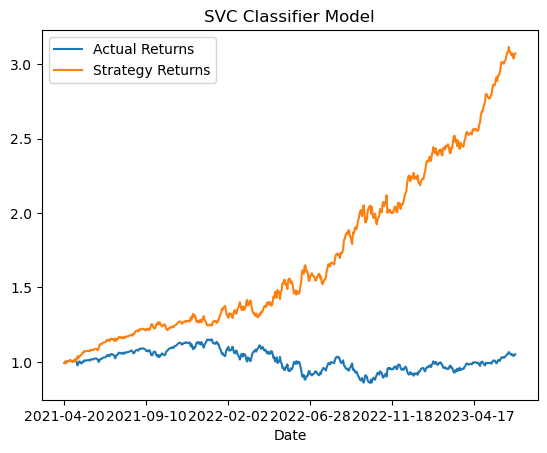

In [77]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[['Actual Returns','Strategy Returns']]).cumprod().plot(title='SVC Classifier Model')

#### 2. Decision Tree Classifier

In [81]:
# Initiate the model instance
decision_tree = DecisionTreeClassifier(random_state=101, max_depth=5)

In [83]:
# Fit the model using the training data
model =  decision_tree.fit(X_train_scaled,y_train)

# Use the testing dataset to generate the predictions for the new model
pred = decision_tree.predict(X_test_scaled)

# Review the model's predicted values
pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
       -1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1,
       -1, -1, -1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1,
        1, -1,  1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1

In [84]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report = classification_report(y_test, pred)

# Print the classification report
print(testing_report)

              precision    recall  f1-score   support

          -1       0.69      0.85      0.76       231
           1       0.87      0.72      0.79       320

    accuracy                           0.77       551
   macro avg       0.78      0.78      0.77       551
weighted avg       0.79      0.77      0.77       551



In [85]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_dt_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_dt_df['Predicted'] = pred

# Add the actual returns to the DataFrame
predictions_dt_df['Actual Returns'] = SPY_data_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_dt_df['Strategy Returns'] = SPY_data_df["Actual Returns"] * predictions_dt_df['Predicted'].shift()


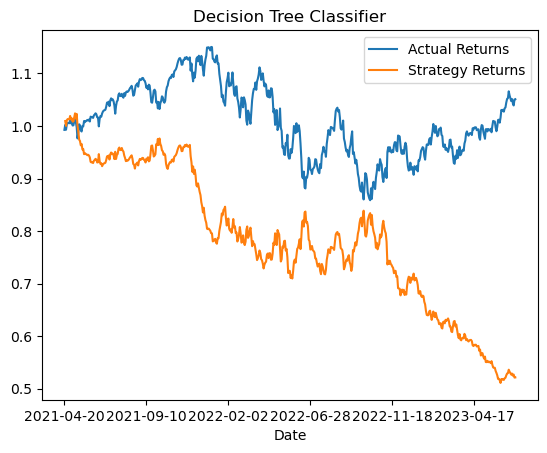

In [86]:
# Plot the actual returns versus the strategy returns
DTree_SMA_best_plot = (1 + predictions_dt_df[["Actual Returns","Strategy Returns"]]).cumprod().plot(title='Decision Tree Classifier').get_figure()
DTree_SMA_best_plot.savefig('DTree_SMA_best_Plot.png')

[Text(0.5387931034482759, 0.9166666666666666, 'X[11] <= -0.27\ngini = 0.455\nsamples = 1761\nvalue = [616, 1145]'),
 Text(0.27586206896551724, 0.75, 'X[11] <= -0.88\ngini = 0.315\nsamples = 637\nvalue = [512, 125]'),
 Text(0.13793103448275862, 0.5833333333333334, 'X[11] <= -1.304\ngini = 0.125\nsamples = 344\nvalue = [321, 23]'),
 Text(0.06896551724137931, 0.4166666666666667, 'X[6] <= -1.283\ngini = 0.021\nsamples = 187\nvalue = [185, 2]'),
 Text(0.034482758620689655, 0.25, 'X[9] <= -1.038\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.017241379310344827, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.05172413793103448, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.10344827586206896, 0.25, 'X[11] <= -1.397\ngini = 0.011\nsamples = 185\nvalue = [184, 1]'),
 Text(0.08620689655172414, 0.08333333333333333, 'gini = 0.0\nsamples = 156\nvalue = [156, 0]'),
 Text(0.1206896551724138, 0.08333333333333333, 'gini = 0.067\nsamples = 29\nvalu

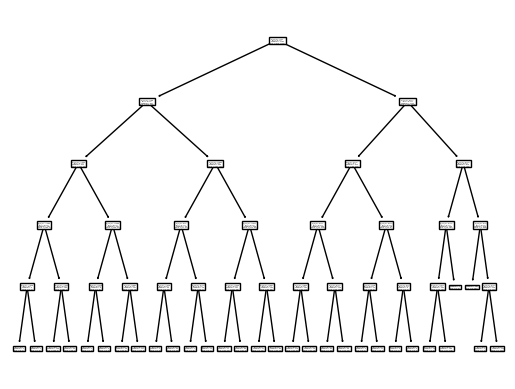

In [87]:
# Check the model
plot_tree(model)

In [ ]:
#### 1. RNN Model and Neural Networks (work in progress - please ignore)

In [88]:
# Build the RNN model
model = keras.Sequential()
# Add layers to the model (e.g., LSTM layers)
# Specify activation functions, number of units, etc.

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the RNN model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32)

# Evaluate the RNN model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Make predictions on new, unseen data
# prediction = model.predict(new_data)


Epoch 1/100
56/56 [==============================] - 0s 2ms/step - loss: 3.0414 - accuracy: 5.6786e-04
Epoch 2/100
56/56 [==============================] - 0s 2ms/step - loss: 3.0414 - accuracy: 5.6786e-04
Epoch 3/100
56/56 [==============================] - 0s 2ms/step - loss: 3.0414 - accuracy: 5.6786e-04
Epoch 4/100
56/56 [==============================] - 0s 2ms/step - loss: 3.0414 - accuracy: 5.6786e-04
Epoch 5/100
56/56 [==============================] - 0s 2ms/step - loss: 3.0414 - accuracy: 5.6786e-04
Epoch 6/100
56/56 [==============================] - 0s 2ms/step - loss: 3.0414 - accuracy: 5.6786e-04
Epoch 7/100
56/56 [==============================] - 0s 2ms/step - loss: 3.0414 - accuracy: 5.6786e-04
Epoch 8/100
56/56 [==============================] - 0s 2ms/step - loss: 3.0414 - accuracy: 5.6786e-04
Epoch 9/100
56/56 [==============================] - 0s 2ms/step - loss: 3.0414 - accuracy: 5.6786e-04
Epoch 10/100
56/56 [==============================] - 0s 2ms/step - loss:

In [89]:
"float64"])
)
new_data = np.reshape(new_data.values, (new_data.shape[0], new_data.shape[1], 1))

new_prediction = model.predict(new_data)
predicted_class = 1 if new_prediction[0] > 0.5 else 0
print("New data prediction:", predicted_class)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
# Split the preprocessed data into a training and testing dataset
# Assign the function a random_state equal to 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Fit the scaler to the features training dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled =  X_scaler.transform(X_test)

In [ ]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features

In [ ]:
# Define the number of neurons in the output layer
number_output_neurons = 1

# Define the number of hidden nodes for the first hidden layer (using average)
hidden_nodes_layer1 =  (number_input_features + number_output_neurons) //2

# Review the number hidden nodes in the first layer
hidden_nodes_layer1

In [ ]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 =  (hidden_nodes_layer1 + number_output_neurons) //2

# Review the number hidden nodes in the second layer
hidden_nodes_layer2

In [ ]:
# Create the Sequential model instance
neuron = Sequential()

In [ ]:
# Add the first hidden layer
neuron.add(Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))
# Add the second hidden layer
neuron.add(Dense(units=hidden_nodes_layer2, activation="relu", input_dim=number_input_features))

In [ ]:
# Add the output layer to the model specifying the number of output neurons and activation function
neuron.add(Dense(units=number_output_neurons, activation="sigmoid"))

In [ ]:
# Display the Sequential model summary
neuron.summary()

In [ ]:
# Compile the Sequential model
neuron.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Fit the model using 50 epochs and the training data
model = neuron.fit(X_train_scaled, y_train, epochs=50)

In [ ]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = neuron.evaluate(X_test_scaled, y_test, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# Load the data
data = pd.read_csv("DIA_data.csv")

# Filter out instances with class 0
data = data[data["Signal"] != 0]



# Split the data into features (X) and target variable (y)
X = data.drop("Signal", axis=1)  # Replace "is_up" with the actual target column name
y = data["Signal"]
y = y.reshape(-1, 1)
np.array(y)
display(y)

# Convert categorical columns to numerical representations
label_encoder = LabelEncoder()
for col in X.select_dtypes(include=["object"]).columns:
    X[col] = label_encoder.fit_transform(X[col])

# Scale the numerical features
scaler = StandardScaler()
X[X.select_dtypes(include=["float64"]).columns] = scaler.fit_transform(X.select_dtypes(include=["float64"]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the target variable to a 1D array
y_train = np.array(y_train).reshape(-1)
y_test = np.array(y_test).reshape(-1)

# Reshape the input data for RNN
X_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

# Create the RNN model
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation="sigmoid"))  # Use sigmoid activation for binary classification

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Make predictions on new data
new_data = pd.DataFrame({
    "feature_1": ["Signal"],
    "feature_2": ["Close"]
    # Add more feature values as per your dataset
})

new_data[new_data.select_dtypes(include=["object"]).columns] = label_encoder.transform(
    new_data[new_data.select_dtypes(include=["object"]).columns]
)
new_data[new_data.select_dtypes(include=["float64"]).columns] = scaler.transform(
    new_data.select_dtypes(include=["float64"])
)
new_data = np.reshape(new_data.values, (new_data.shape[0], new_data.shape[1], 1))

new_prediction = model.predict(new_data)
predicted_class = 1 if new_prediction[0] > 0.5 else 0
print("New data prediction:", predicted_class)
